## Introduction:


Filename: Cars_1985_Risky_v2.py

Author: Abhay Mulbagal Suchindra

Purpose: Classify the riskiness of cars based on their attributes and validate against the symboling 

Data Source: 1985 Ward's Automotive Yearbook 
< https://archive.ics.uci.edu/ml/datasets/automobile >

Creation Date: 20 Mar 2019
###############################################################################

#### Modifications:

30 Mar 2019 : Formatting, EDA

#### Problem Description:

Given the 24 attributes of cars, the riskiness in terms of crashes is to be determined.
The riskiness is described by a 'symboling' defined by actuarians
The task at hand is to see if we can assign a symboling based on the other features, using regression
We are able to use regression instead of classification, as the symboling is on a scale from -3 to +3, 
and not in non-comparable categories.


## Libraries:

In [1]:
## import the required libraries:

import os
import pandas as pd
import numpy as np
from plotly import plotly
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


## Directory and File Import:

In [2]:
#### Set the working directory:

os.chdir("D:/AVM/Cars 1985")

#### Import the required file and get a dataframe for analysis:

df = pd.read_csv('imports-85.data.csv' , header = None)


## Column Cleanup:

In [3]:
## Write the column names per description:

header_list = ['symboling'
               , 'normalized-losses'
               , 'make'
               , 'fuel-type'
               , 'aspiration'
               , 'num-of-doors'
               , 'body-style'
               , 'drive-wheels'
               , 'engine-location'
               , 'wheel-base'
               , 'length'
               , 'width'
               , 'height'
               , 'curb-weight'
               , 'engine-type'
               , 'num-of-cylinders'
               , 'engine-size'
               , 'fuel-system'
               , 'bore'
               , 'stroke'
               , 'compression-ratio'
               , 'horsepower'
               , 'peak-rpm'
               , 'city-mpg'
               , 'highway-mpg'
               , 'price']


## Change the header names from the relavant list above:

df.columns = header_list

# First replace '?' with 'NaN':

df.replace("?", np.nan, inplace = True)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


## Initial EDA:

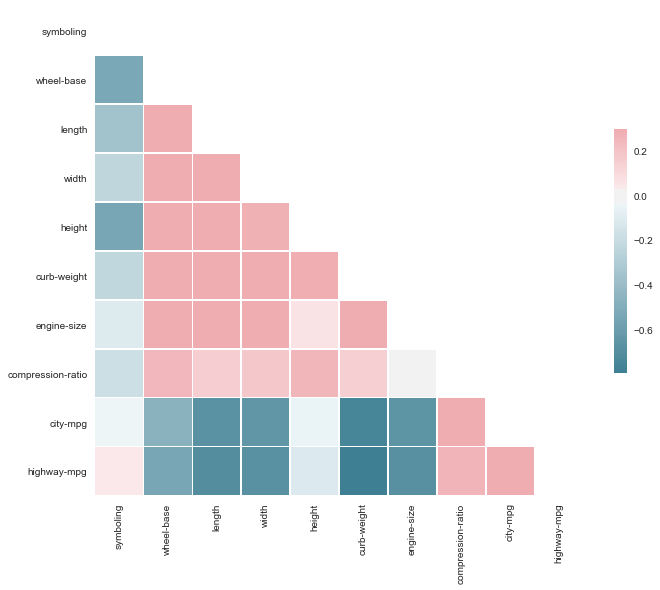

In [4]:
# Compute the correlation matrix
corr = df.corr()
sns.set(style = "white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5})

# Looking at the heatmap, we don't see much correlation among variables, expect for an inverse mpg to engine size, which makes sense


## Missing Value Treatment:

In [5]:
# Moving on to missing data treatment:
# is.null() gives us the occurences where the data is null/missing
missing_data = df.isnull().sum()
missing_data.sort_values(inplace = True, ascending = False)
print(missing_data.head())

## Here we see that normalized-losses column has the most number of missing data. 

# It is tough to predict the prices and to treat the missing values here. We remove such occurences
df.dropna(subset = ["price"], axis = 0, inplace = True)

# reset index, because we droped two rows
df.reset_index(drop = True, inplace = True)
df.head()

# We can replace the values for the others with the mean of the respective columns

#avg_norm_loss = df["normalized-losses"].astype("float").mean(axis = 0)
avg_bore = df['bore'].astype('float').mean(axis = 0)
avg_stroke = df["stroke"].astype("float").mean(axis = 0)
avg_horsepower = df['horsepower'].astype('float').mean(axis = 0)
avg_peakrpm = df['peak-rpm'].astype('float').mean(axis = 0)

#df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace = True)
df["bore"].replace(np.nan, avg_bore, inplace = True)
df["stroke"].replace(np.nan, avg_stroke, inplace = True)
df['horsepower'].replace(np.nan, avg_horsepower, inplace = True)
df['peak-rpm'].replace(np.nan, avg_peakrpm, inplace = True)

normalized-losses    41
price                 4
stroke                4
bore                  4
peak-rpm              2
dtype: int64


## Verify Datatypes of Columns:

In [6]:
## We check the datatypes of all the variables:

obj_df = df.select_dtypes(include = ['object']).copy()
#print(obj_df.head())

#print(df.dtypes)

# Check if there are any missing values in the object-only dataframe
test = obj_df[obj_df.isnull().any(axis = 1)]
missing_data = obj_df.isnull().sum()
missing_data.sort_values(inplace = True, ascending = False)
#print(missing_data.head())

# Replace the number-of-doors missing value with 'four' as it is more frequent
obj_df = obj_df.fillna({"num-of-doors": "four"})

# Now replace the text numbers e.g 'four' & 'two' to the respective numbers i.e. '4' & '2':
cleanup_nums = {"num-of-doors":     {"four": 4, "two": 2},
                "num-of-cylinders": {"twelve": 12, "eight": 8,"six": 6, "five": 5, "four": 4, "three": 3, "two": 2}}

obj_df.replace(cleanup_nums, inplace = True)


##  Create Dummy Variables for Categorical Variables:

In [7]:
## Get dummy variables for all other categorical variables, in the form of binary 0 or 1.
# this method is important because we cannot rank the makes into 0,1,2... or say that a convertible is 'n' times a sedan
# the dummy variables will create the variables in the form of is-true or not. Presence of or not.

dummy_var_df = pd.get_dummies(obj_df,
                              columns = ["make"
                                ,"fuel-type"
                                ,"aspiration"
                                ,"body-style"
                                ,"drive-wheels"
                                ,"engine-location"
                                ,"engine-type"
                                ,"fuel-system"], 
                              prefix = ["make"
                                ,"fuel-type"
                                ,"aspiration"
                                ,"body-style"
                                ,"drive-wheels"
                                ,"engine-location"
                                ,"engine-type"
                                ,"fuel-system"])

# When making dummy variables from a previous column containing values A, B, & C - the dummy variables for A & B should suffice
# because when A & B  values are both 0, it means that the corresponding C should automatically be 1. So, we can drop column C.
# Keeping all three, (as has been done in this code) makes it a little slower. However, we are dealing with only 200 rows 
# so the speed won't change much. Moreover, the current code is more dynamic. In case of an additional value D, in a later 
# iteration the removal of C (or the last column) needs to be made dynamic

# Next steps : Make the removal of one dummy variable from each object dynamic ( remove C or D, based on whether the unique 
# values in the original object are 3 or 4 respectively)

# Change the datatype for the last few columns:
dummy_var_df['bore'] = pd.to_numeric(dummy_var_df['bore'])
dummy_var_df['stroke'] = pd.to_numeric(dummy_var_df['stroke'])
dummy_var_df['horsepower'] = pd.to_numeric(dummy_var_df['horsepower'])
dummy_var_df['peak-rpm'] = pd.to_numeric(dummy_var_df['peak-rpm'])
dummy_var_df['price'] = pd.to_numeric(dummy_var_df['price'])
# dummy_var_df.dtypes


# Now the data is prepared and we are good to go

##  Create Training and Testing Data Split:

In [8]:
# Create a dataframe with the non-object datatype columns from the original dataframe:
non_obj_df = df.select_dtypes(include = ['int64', 'float64']).copy()

## Proceed to merging the dataframes back together:

df_clean = non_obj_df.join(dummy_var_df, how = 'outer')

## We look at regressing the symboling based on the features except 'normalized-losses'
# We can split the data into train and test based on whether the value of 'normalized-losses' exists or not
# It is an arbitary split, just to test the model. No relevance of 'normalized-losses' at this point of time

df_clean["normalized-losses"].replace(np.nan, 'unavailable', inplace=True)

df_train = df_clean.loc[df_clean['normalized-losses'] != 'unavailable']
df_test = df_clean.loc[df_clean['normalized-losses'] == 'unavailable']
df_train = df_train.drop(['normalized-losses'], axis = 1)
df_test = df_test.drop(['normalized-losses'], axis = 1)


##  Checks for Regression:

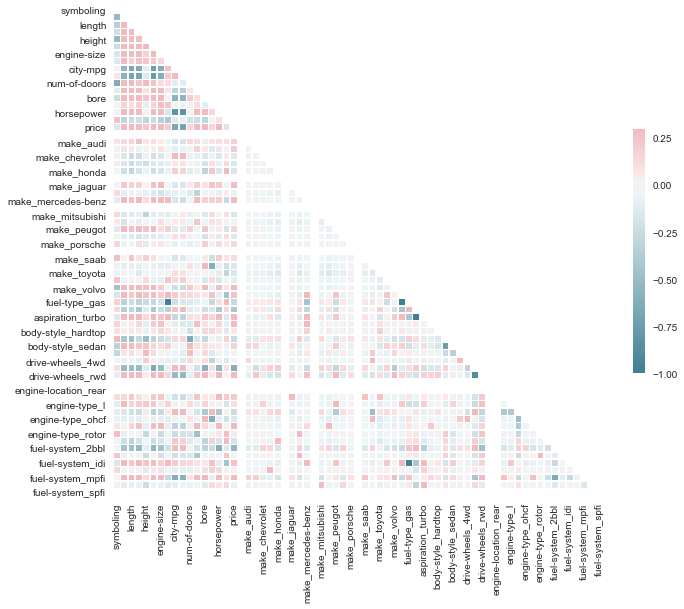

In [9]:
# Compute the correlation matrix
corr = df_train.corr()
sns.set(style = "white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5})

# The correlation seems to be low even after dummy variables creation so we can proceed with the multiple linear regression

##  Multiple Linear Regression:

In [10]:
# Create a multiple linear regression model:
X = df_train.drop(['symboling'], axis = 1) # here we put all the predictor variables (columns except symboling)
Y = df_train['symboling']
 
# Regression Statistics with statsmodels  

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())
    
# Predict with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# print('Intercept: \n', regr.intercept_)
# print('Coefficients: \n', regr.coef_)

pred_var_df = df_test.drop(['symboling'], axis = 1)
pred_out_list = regr.predict(pred_var_df)

# Cap the values to +3 and -3. Round off to nearest integer
treated_pred = []
for i in pred_out_list:
    
    if i < -3:
        i = -3
    elif i > 3:
        i = 3
    else:
        i = round(i,0)
    if i == -0:
        i = 0
    treated_pred.append(i)
        
act_list = df_test['symboling']

                            OLS Regression Results                            
Dep. Variable:              symboling   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     16.27
Date:                Mon, 01 Apr 2019   Prob (F-statistic):           2.13e-33
Time:                        00:51:06   Log-Likelihood:                -93.073
No. Observations:                 164   AIC:                             288.1
Df Residuals:                     113   BIC:                             446.2
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
wheel-base                -0

##  Accuracy Checks:

In [11]:
# Measure of accuracy:

accuracy_check = pd.DataFrame({'Actuals':act_list, 'Prediction': treated_pred})

accuracy_check['Mismatch'] = abs(accuracy_check['Actuals'] - accuracy_check['Prediction'])

print(accuracy_check)
print(accuracy_check.groupby('Mismatch').count())
print(accuracy_check.groupby(['Prediction' , 'Mismatch'] ).count())

## Results obtained:
# The scale of symboling varies from -3 to +3. 
# The accuracy is marked based on the deviation from the true value in whole numbers. 
# The model is spot on 18/37 (49%) instances.


     Actuals  Prediction  Mismatch
0          3         3.0       0.0
1          3         3.0       0.0
2          1         2.0       1.0
5          2         3.0       1.0
7          1         1.0       0.0
13         1         0.0       1.0
14         0         0.0       0.0
15         0         1.0       1.0
16         0         0.0       0.0
42         0         1.0       1.0
43         2         2.0       0.0
45         0         0.0       0.0
46         0         3.0       3.0
60         0         0.0       0.0
63         0         0.0       0.0
68        -1        -1.0       0.0
70         0        -1.0       1.0
71         1         1.0       0.0
72         1         1.0       0.0
79         3         2.0       1.0
80         3         2.0       1.0
81         3         2.0       1.0
106        0        -1.0       1.0
107        0        -1.0       1.0
110        0         0.0       0.0
111        0        -1.0       1.0
121        3         1.0       2.0
123        3        